In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import glob
from h5_util import concatenate_files, load_h5
                
def violin_plot(to_plot, title=None, xlabel=None, ylabel=None, labels=None, savefig=None):
    
    fig = plt.figure()

    # Create an axes instance
    ax = fig.add_axes([0,0,1,1])

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if labels is not None:
        set_axis_style(ax, labels)

    # Create the boxplot
    bp = ax.violinplot(to_plot, showmedians=True, showmeans=True)
    bp['cmeans'].set_color('white')
    bp['cmedians'].set_color('black')
    for pc in bp['bodies']:
        #pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)
    if savefig is not None:
        fig.savefig(savefig, format='pdf', bbox_inches="tight")
    plt.show()
    
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

def group(key, metric, discard=None, action='append'):
    res = dict()
    for k,v in zip(key, metric):
        if discard is not None and discard(v):
            continue
        if action=='sum':
            res[k] = res.get(k, 0) + v
        elif action=='unique':
            if k not in res:
                res[k] = v
        else:
            if k not in res:
                res[k] = []
            res[k].append(v)
    return res
        
src_dir = 'data/gastric_tum19'

In [3]:
data = load_h5(os.path.join(src_dir, "info.h5"))

In [4]:
for key,value in data.items():
    print(key)
    for k,v in value.items():
        print(k,v.shape)

global
alleles (37331,)
alleles_kept (37331,)
chrom (37331,)
motif_len (37331,)
n_reads (37331,)
n_reads_corr (37331,)
n_umi (37331,)
n_umi_corr (37331,)
nucl (37331,)
pos (37331,)
umi
alleles (40669,)
avg_qual (40669,)
cfreq (40669,)
chrom (40669,)
count (40669,)
freq (40669,)
motif_len (40669,)
nucl (40669,)
pos (40669,)
qual (40669,)


### At umi level

In [5]:
data_umi = data['umi']

#### Frequency of selected indel

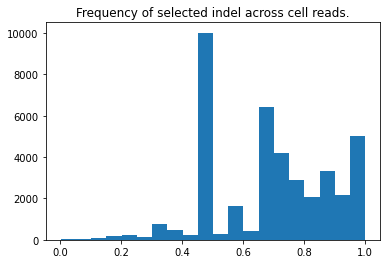

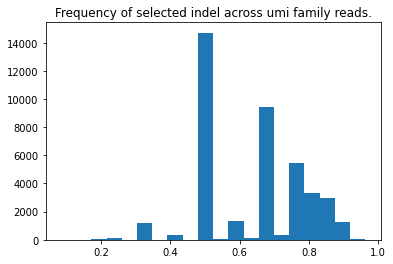

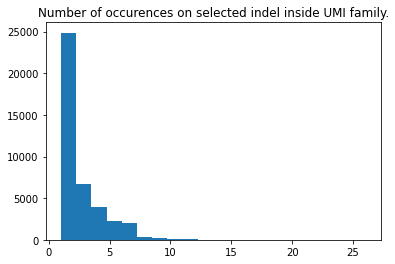

In [6]:
plt.hist(data_umi['cfreq'], bins=20)
plt.title('Frequency of selected indel across cell reads.')
plt.show()
plt.hist(data_umi['freq'], bins=20)
plt.title('Frequency of selected indel across umi family reads.')
plt.show()
plt.hist(data_umi['count'], bins=20)
plt.title('Number of occurences on selected indel inside UMI family.')
plt.show()

#### Selected indel base quality vs frequency

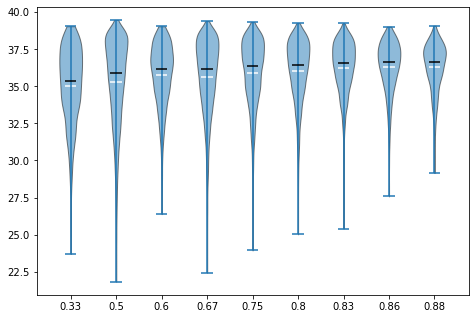

In [13]:
#freq = np.round(data_umi['freq'], 1)
freq = data_umi['freq']
uni, counts = np.unique(freq, return_counts=True)
asort = np.argsort(counts)
i = next(i for i,x in enumerate(asort[-1::-1]) if counts[x]<500)
uni = sorted(uni[asort[-i:]])
to_plot = []
for f in uni:
    qf = data_umi['avg_qual'][freq==f]
    #qf = np.clip(qf, 30, 40)
    to_plot.append(qf)
violin_plot(
    to_plot,
    labels=tuple(np.round(uni,2))
)
plt.show()

### At (site, cell) level

In [21]:
data_global = data['global']

#### Proportion of discordant reads per motif type at site level

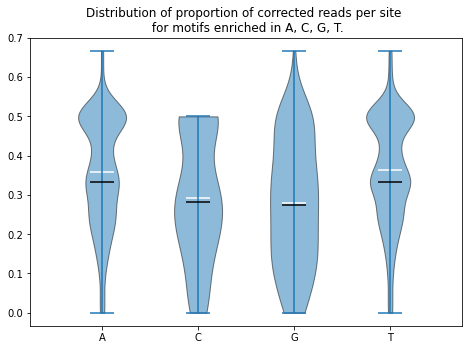

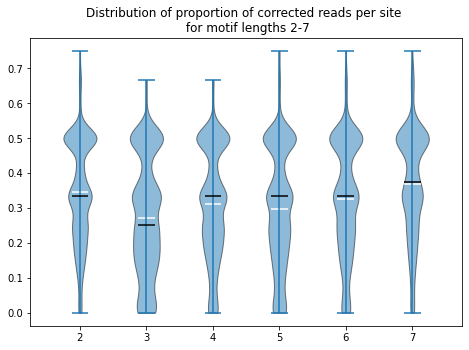

In [18]:
pos = data['global']['pos']

n_corr = group(pos, data_global['n_reads_corr'], action='sum')
n_reads = group(pos, data_global['n_reads'], action='sum')
props = {k: n_corr[k]/n_reads[k] for k in n_corr.keys()}

to_discard = lambda x: x-0.001-int(x)<0.5
nucls = group(pos, data_global['nucl'], discard=to_discard, action='unique')
to_keep = nucls.keys()

props_arr = np.array([props[k] for k in to_keep])
nucls_arr = np.array([chr(int(nucls[k]-0.001)) for k in to_keep])


acgt = ['A', 'C', 'G', 'T']
to_plot = []
for c in acgt:
    pc = props_arr[nucls_arr==c]
    #pc = np.clip(pc, 0, 1)
    to_plot.append(pc)
violin_plot(
    to_plot,
    labels=tuple(acgt),
    title='Distribution of proportion of corrected reads per site \n for motifs enriched in A, C, G, T.'
)
plt.show()

props_arr = np.array([props[k] for k in props])
motif_len = group(pos, data_global['motif_len'], action='unique')
motif_len_arr = np.array([motif_len[k] for k in props])
uni = np.unique(motif_len_arr)

to_plot = []
for l in uni:
    pl = props_arr[motif_len_arr==l]
    #pf = np.clip(pf, 0, 1)
    to_plot.append(pl)
violin_plot(
    to_plot,
    labels=tuple(uni),
    title='Distribution of proportion of corrected reads per site \n for motif lengths 2-7'
)
plt.show()

#### Proportion of corrected reads & umis

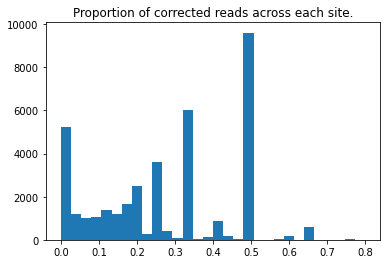

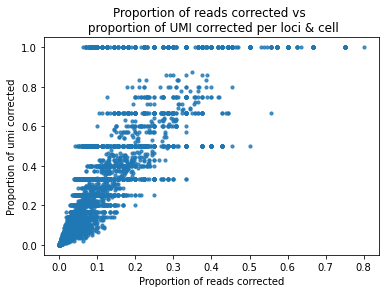

In [19]:
X = np.divide(data['global']['n_reads_corr'], data['global']['n_reads'])
Y = np.divide(data['global']['n_umi_corr'], data['global']['n_umi'])
plt.hist(X, bins=30)
plt.title('Proportion of corrected reads across each site.')
plt.show()
plt.scatter(X, Y, alpha=0.8, s=10)
plt.title('Proportion of reads corrected vs \n proportion of UMI corrected per loci & cell')
plt.xlabel('Proportion of reads corrected')
plt.ylabel('Proportion of umi corrected')
plt.show()

In [20]:
for k,v in data['umi'].items():
    u,c = np.unique(v, return_counts=True)
    if len(u)<30:
        print(k)
        print(list(zip(u,c)))

alleles
[(2, 38091), (3, 2399), (4, 166), (5, 13)]
chrom
[(1, 4903), (2, 2303), (3, 3313), (4, 1136), (5, 1503), (6, 2018), (7, 1880), (8, 1090), (9, 1381), (10, 1220), (11, 2995), (12, 2043), (13, 591), (14, 1489), (15, 1103), (16, 1653), (17, 3333), (18, 633), (19, 2238), (20, 893), (21, 327), (22, 966), (88, 1646), (89, 12)]
count
[(1, 14036), (2, 10825), (3, 6686), (4, 3979), (5, 2254), (6, 1301), (7, 764), (8, 379), (9, 202), (10, 96), (11, 49), (12, 24), (13, 28), (14, 13), (15, 12), (16, 7), (17, 4), (18, 5), (19, 2), (20, 1), (21, 1), (26, 1)]
motif_len
[(2, 9140), (3, 11306), (4, 6025), (5, 6068), (6, 5047), (7, 3083)]
qual
[(0.0, 40669)]
